In [1]:
pip install filterpy

     |████████████████████████████████| 184kB 2.7MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp36-none-any.whl size=110451 sha256=4bc076db52e5042a8bdbbc1d316e3c5ead5b63fb2b1a9d115d9d9081996ba56c
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


In [2]:
from filterpy.kalman import ExtendedKalmanFilter as EKF
from numpy import dot, array, sqrt
from numpy.random import randn
from math import atan2, sqrt
import sympy
from sympy import symbols, Matrix
from sympy.abc import beta, x, y, v, R, theta

class RobotEKF(EKF):
    def __init__(self, dt, std_vel, std_steer):
        EKF.__init__(self, 3, 2, 2)
        self.dt = dt
        self.std_vel = std_vel
        self.std_steer = std_steer

        beta, x, y, v, theta, time = symbols(
            'beta, x, y, v, theta, t')
        d = v*time
    
        self.fxu = Matrix([[x + d*sympy.sin(theta+beta)],
                           [y + d*sympy.cos(theta+beta)],
                           [theta+beta]])

        self.F_j = self.fxu.jacobian(Matrix([x, y, theta]))
        self.V_j = self.fxu.jacobian(Matrix([v, beta]))

        # save dictionary and its variables for later use
        self.subs = {x: 0, y: 0, v:0, beta:0, 
                     time:dt, theta:0}
        self.x_x, self.x_y, = x, y 
        self.v, self.beta, self.theta = v, beta, theta

    def predict(self, u=0):
        self.x = self.move(self.x, u, self.dt)
        self.subs[self.theta] = self.x[2, 0]
        self.subs[self.v] = u[0]
        self.subs[self.beta] = u[1]

        F = array(self.F_j.evalf(subs=self.subs)).astype(float)
        V = array(self.V_j.evalf(subs=self.subs)).astype(float)

        # covariance of motion noise in control space
        M = array([[self.std_vel**2, 0], 
                   [0, self.std_steer**2]])

        self.P = dot(F, self.P).dot(F.T) + dot(V, M).dot(V.T)

    def move(self, x, u, dt):
        theta = x[2, 0]
        vel = u[0]
        beta = u[1]
        dist = vel * dt
        new_theta = (theta + beta) % (2 * np.pi)
        if new_theta > np.pi:             # move to [-pi, pi)
            new_theta -= 2 * np.pi

        new_x = np.array([[x[0, 0] + dist*sin(new_theta)], 
                          [x[1, 0] + dist*cos(new_theta)], 
                          [new_theta]])
        return new_x

In [3]:
def H_of(x):
    """ compute Jacobian of H matrix where h(x) computes 
    the range and bearing to a landmark for state x """
    H = array(
        [[1, 0, 0],
         [0, 1, 0],
         [0, 0, 1],])
    
    return H

def Hx(x):
    """ takes a state variable and returns the measurement
    that would correspond to that state. """
    Hx = array([[x[0, 0]],
                [x[1, 0]],
                [x[2, 0]]])
    
    return Hx

def residual(a, b):
    """ compute residual (a-b) between computed measurement and 
    machine measurement containing [range, bearing]. 
    Bearing is normalized to [-pi, pi)"""
    y = a - b
    y[2] = y[2] % (2 * np.pi)    # force in range [0, 2 pi)
    if y[2] > np.pi:             # move to [-pi, pi)
        y[2] -= 2 * np.pi
    return y

def get_measurement(sim_pos, std_rng, std_brg):
    """ simulate measurement by adding random noise within variance range """
    x, y, theta = sim_pos[0, 0], sim_pos[1, 0], sim_pos[2, 0]
    noised_theta = (theta + randn()*std_brg) % (2 * np.pi)
    if noised_theta > np.pi:  # move to [-pi, pi)
        noised_theta -= 2 * np.pi
    z = np.array([[x + randn()*std_rng],
                  [y + randn()*std_rng],
                  [noised_theta]])
    return z

def reach_goal(current_state, goal_state, tol=.1):
    """ check whether goal state is reached """
    if np.absolute(current_state[0,0] - goal_state[0,0]) < tol and np.absolute(current_state[1,0] - goal_state[1,0]) < tol:
      return True
    else:
      return False

In [17]:
from math import sqrt, tan, cos, sin, atan2
import matplotlib.pyplot as plt
import numpy as np

dt = 0.1

def run_navigation(start_state, goal_state, init_var, tol, std_vel, std_steer, 
                     std_range, std_bearing,
                     step=10, ellipse_step=50, ylim=None):
    ekf = RobotEKF(dt, std_vel=std_vel, 
                   std_steer=std_steer)
    ekf.x = start_state         # x, y, steer angle
    # initialize state variance P and measurement variance R
    ekf.P = np.diag([init_var[0], init_var[1], init_var[2]])
    ekf.R = np.diag([std_range**2, std_range**2, std_bearing**2])

    ideal_state = ekf.x.copy() # simulated position
    
    ideal_track = []
    ekf_track = []

    # simulated movement, i.e. half circle
    while not reach_goal(ekf.x, goal_state, tol=tol):
        # get control
        u = array([1.0, .02])  # steering command (vel, steering angle change)
        # u = get_control(current_state, goal_state)

        # ideal movement of robot
        ideal_state = ekf.move(ideal_state, u, dt)
        # keep track of the ideal path
        ideal_track.append(ideal_state)

        # apply noise to control and measurement with EKF
        ekf.predict(u=u)
        z = get_measurement(ekf.x, std_range, std_bearing)
        ekf.update(z, HJacobian=H_of, Hx=Hx, residual=residual)
        # keep track of the EKF path
        ekf_track.append(ekf.x)

    ideal_track = np.array(ideal_track)
    ekf_track = np.array(ekf_track)

    plt.figure()
    plt.scatter(goal_state[0, 0], goal_state[1, 0], marker='s', s=60)
    plt.plot(ideal_track[:,0], ideal_track[:,1], color='b', lw=2)
    plt.plot(ekf_track[:, 0], ekf_track[:,1], color='r', lw=2)
    plt.axis('equal')
    plt.title("EKF Robot localization")
    if ylim is not None: plt.ylim(*ylim)
    plt.show()
    return ekf

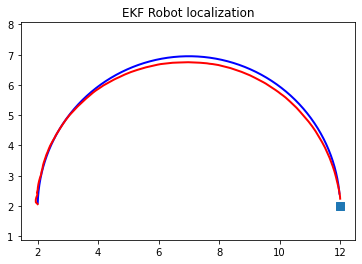

Legend
Blue: ideal path
Red: EKF path
Square: goal
Final P: [2.34326406e-04 8.92150335e-04 6.17922165e-05]


In [ ]:

start_state = array([[2.0, 2.0, 0.0]]).T
goal_state = array([[12.0, 2.0]]).T
init_var = [0.1, 0.1, 0.01]   # initial std for state variables x, y and theta

ekf = run_navigation(
    start_state=start_state, goal_state=goal_state, init_var=init_var, tol=.3,
    std_vel=0.1, std_steer=0.01,
    std_range=0.1, std_bearing=0.01)
print('Legend')
print('Blue: ideal path')
print('Red: EKF path')
print('Square: goal')
print('Final P:', ekf.P.diagonal())

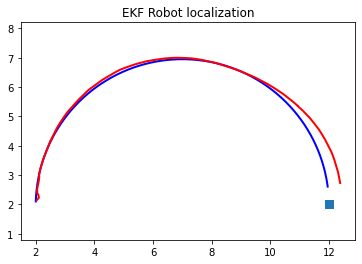

Legend
Blue: ideal path
Red: EKF path
Square: goal
Final P: [3.33685825e-04 3.79794778e-03 9.62814373e-05]


In [ ]:
start_state = array([[2.0, 2.0, 0.0]]).T
goal_state = array([[12.0, 2.0]]).T
init_var = [0.1, 0.1, 0.01]   # initial std for state variables x, y and theta

ekf = run_navigation(
    start_state=start_state, goal_state=goal_state, init_var=init_var, tol=.8,
    std_vel=0.5, std_steer=0.05,
    std_range=0.1, std_bearing=0.01)
print('Legend')
print('Blue: ideal path')
print('Red: EKF path')
print('Square: goal')
print('Final P:', ekf.P.diagonal())

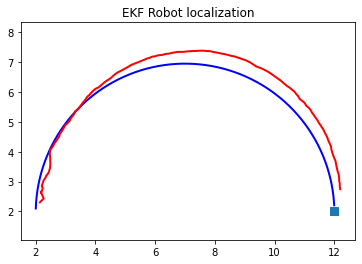

Legend
Blue: ideal path
Red: EKF path
Square: goal
Final P: [0.00351316 0.00430287 0.00045183]


In [19]:
start_state = array([[2.0, 2.0, 0.0]]).T
goal_state = array([[12.0, 2.0]]).T
init_var = [0.1, 0.1, 0.01]   # initial std for state variables x, y and theta

ekf = run_navigation(
    start_state=start_state, goal_state=goal_state, init_var=init_var, tol=.8,
    std_vel=0.1, std_steer=0.01,
    std_range=0.5, std_bearing=0.05)
print('Legend')
print('Blue: ideal path')
print('Red: EKF path')
print('Square: goal')
print('Final P:', ekf.P.diagonal())

In [ ]:
start_state = array([[2.0, 2.0, 0.0]]).T
goal_state = array([[12.0, 2.0]]).T
init_var = [0.1, 0.1, 0.01]   # initial std for state variables x, y and theta

ekf = run_navigation(
    start_state=start_state, goal_state=goal_state, init_var=init_var, tol=1.0,
    std_vel=0.5, std_steer=0.05,
    std_range=0.5, std_bearing=0.05)
print('Legend')
print('Blue: ideal path')
print('Red: EKF path')
print('Square: goal')
print('Final P:', ekf.P.diagonal())